## Data Exploration

In [1]:
import pandas as pd
import numpy as np

In [2]:
csv_path = 'data/btc_usd_weekly.csv'

In [3]:
df = pd.read_csv(csv_path)

In [4]:
# remove 1 nan row and column adj close
df = df.dropna().reset_index(drop=True)
df = df.drop('Adj Close', axis=1)

### Compute Percentual change and create labels

In [5]:
df['Change'] = (df['Close'] - df['Open'])
df['Percentual Change'] = (df['Change'] / df['Open']) * 100

In [6]:
def decide_label(row):
    label = 0
    if row['Percentual Change'] > 0.5:
        label = 1
    return label

In [7]:
df['Buy'] = df.apply(decide_label, axis=1) 

In [8]:
def calculate_variation(df: pd.DataFrame):
    variation_lst = []
    variation = 0
    for row in df.iterrows():
        if row[0] == 0:
            pass
        else:
            # print(row[0])
            variation = df.iloc[row[0]]['Change'] - df.iloc[row[0]-1]['Change']
        variation_lst.append(variation)
    return variation_lst

In [9]:
variations_lst = calculate_variation(df)
variations = pd.Series(variations_lst, name='Variation')
df = pd.concat([df, variations], axis=1)

In [10]:
df.head(2)

,Date,Open,High,Low,Close,Volume,Change,Percentual Change,Buy,Variation
0,2015-01-19,211.470993,255.074005,205.153000,253.718002,189165500.0,42.247009,19.977685,1,0.000000
1,2015-01-26,254.078995,309.384003,212.014999,226.972000,306840500.0,-27.106995,-10.668727,0,-69.354004


In [11]:
df['Buy'].value_counts()

Buy
1    243
0    210
Name: count, dtype: int64

In [12]:
# i=0
# for row in df.iterrows():
#     print(row[1]['Open'])
#     if i == 0:
#         break

## Compute RSI

In [13]:
def calculate_rsi(df: pd.DataFrame):
    # Based on https://www.investopedia.com/terms/r/rsi.asp
    rsi_lst = []
    for row in df.iterrows():
        if row[0] < 14:
            rsi = 0
        else:
            up = []
            down = []
            for i in range(row[0] - 14, row[0]):
                if df.iloc[i]['Percentual Change'] > 0:
                    up.append(df.iloc[i]['Percentual Change'])
                else:
                    down.append(df.iloc[i]['Percentual Change'])
            up_mean = np.mean(up) / 14
            down_mean = np.mean(down) / 14

            rs = np.abs(up_mean / down_mean)
            rsi = 100 - (100/(1 + rs))
            
        rsi_lst.append(rsi)
    return rsi_lst

In [14]:
rsi_lst = calculate_rsi(df)
rsi = pd.Series(rsi_lst, name='RSI')
df = pd.concat([df, rsi], axis=1)    

In [18]:
df[14:18]

,Date,Open,High,Low,Close,Volume,Change,Percentual Change,Buy,Variation,RSI
14,2015-04-27,219.429001,243.240005,218.022995,240.358002,162643200.0,20.929001,9.537938,1,24.111008,54.432408
15,2015-05-04,240.356003,247.804001,228.572998,240.296005,166059200.0,-0.059998,-0.024962,0,-20.988999,48.928614
16,2015-05-11,240.298996,244.270004,234.057007,236.802002,130322100.0,-3.496994,-1.455268,0,-3.436996,55.800022
17,2015-05-18,236.886993,241.977997,231.817001,240.953003,114746500.0,4.066010,1.716434,1,7.563004,55.729553


## Data Analysis

In [21]:
features = df.drop(['Buy', 'Date'], axis=1)
labels = df.loc[:,'Buy']

In [25]:
features_selected = features.loc[:, ['RSI', 'Volume']]

In [26]:
data = features_selected[14:]
c = labels[14:]

In [29]:
import matplotlib.pyplot as plt

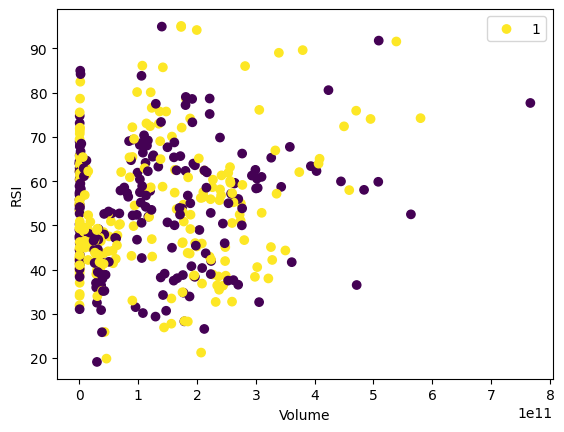

In [42]:
plt.scatter(data['Volume'], data['RSI'], c=c)
plt.xlabel('Volume')
plt.ylabel('RSI')
plt.legend(c)
plt.show()

In [62]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features[14:], c)

In [65]:
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10]}

In [63]:
svc = SVC()

In [66]:
clf = GridSearchCV(svc, parameters)

In [ ]:
clf.fit(features[14:], c)

In [59]:
svc.fit(X_train, y_train)

SVC(C=10)

In [60]:
svc.predict(X_test)

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
      dtype=int64)

In [61]:
score = svc.score(X_test, y_test)
score

0.5454545454545454